In [1]:
import neurogym as ngym
from neurogym.envs.annubes import AnnubesEnv

env = AnnubesEnv()
print(env.timing)
print("----------------")
print(env.observation_space)
print(env.observation_space.name)
print("----------------")
print(env.action_space)
print(env.action_space.name)

{'fixation': 500, 'stimulus': 1000, 'decision': 100}
----------------
Box(0.0, 1.0, (4,), float32)
{'fixation': 0, 'start': 1, 'v': 2, 'a': 3}
----------------
Discrete(2)
{'fixation': 0, 'choice': [0, 1]}


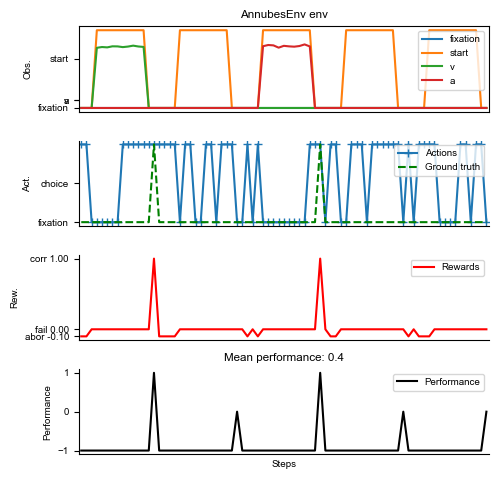

In [2]:
fig = ngym.utils.plot_env(
    env,
    ob_traces=["fixation", "start", "v", "a"],
    num_trials=5,
)

In [3]:
import warnings

from stable_baselines3 import A2C  # ACER, PPO2
from stable_baselines3.common.vec_env import DummyVecEnv

warnings.filterwarnings("default")

# Optional: PPO2 requires a vectorized environment to run
# the env is now wrapped automatically when passing it to the constructor
env = DummyVecEnv([lambda: AnnubesEnv()])

model = A2C("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=1000, log_interval=1000)
env.close()

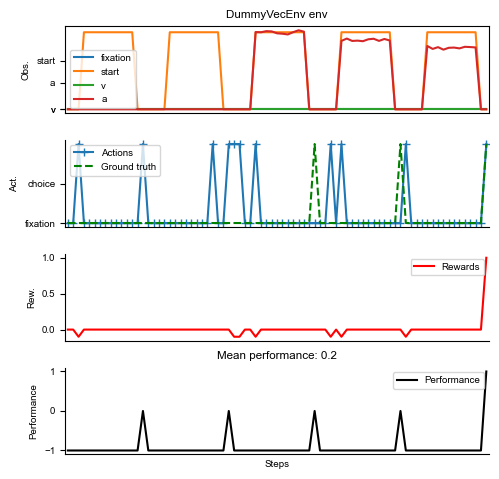

In [4]:
env = AnnubesEnv()
env = DummyVecEnv([lambda: env])
# plot example trials with random agent
data = ngym.utils.plot_env(env, num_trials=5, ob_traces=["fixation", "start", "v", "a"], model=model)